In [88]:
#Importamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [89]:
#Leemos el dataset de entrenamiento.
train = pd.read_csv("train.csv")
print ("Train data shape:", train.shape)
train.head()


Train data shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [90]:
#Leemos el dataset de test.
test = pd.read_csv("test.csv")
testID = test['Id']
print ("Test data shape:", test.shape)
test.head()

Test data shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [91]:
#Reemplazamos los datos nulos.
for col in train:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna(train[col].mode())
    else:
        train[col] = train[col].fillna(train[col].median())

In [92]:
# Aplicamos LabelEncoding 
def label_encoding(df_train,df_test):
    le_count=0;
    for col in df_train:
        if df_train[col].dtype == 'object':
            if len(list(df_train[col].unique())) <= 2:
                le = LabelEncoder()
                le.fit(list(df_train[col].unique())+list(df_test[col].unique()))

                df_train[col] = le.transform(df_train[col].astype(str))
                df_test[col] = le.transform(df_test[col].astype(str))
                le_count +=1;
               
    
    print("Total label encoded columns : %d " %le_count)

In [93]:
label_encoding(train,test)
train.shape
test.shape

Total label encoded columns : 3 


(1459, 80)

In [94]:
#Aplicamos one-hot encoding
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dataset = pd.get_dummies(dataset)
train = copy.copy(dataset[:train_objs_num])
test = copy.copy(dataset[train_objs_num:])
test = test.drop(['SalePrice'],axis=1)
print("Tain : ",train.shape)
print("Test : ",test.shape)

Tain :  (1460, 287)
Test :  (1459, 286)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


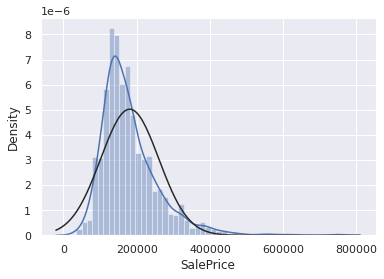

In [95]:
#Graficamos para poder observar la distribución de del precio de venta.
sns.distplot(train['SalePrice'],fit=norm)

In [96]:
#Se buscan las columnas mas relacionadas al precio de venta y se utilizan unicamente esas en el modelo.
corr = train.corr()
corr = corr.sort_values('SalePrice')
cols = corr['SalePrice'][corr['SalePrice'].values > 0.2].index.values
cols

array(['BsmtUnfSF', 'Neighborhood_StoneBr', 'LotShape_IR1',
       'BsmtFullBath', 'PavedDrive_Y', 'BsmtQual_Gd',
       'GarageType_BuiltIn', 'RoofStyle_Hip', 'Electrical_SBrkr',
       'HouseStyle_2Story', 'MSZoning_RL', 'GarageQual_TA', 'CentralAir',
       'FireplaceQu_Ex', 'LotArea', 'GarageCond_TA', 'HalfBath',
       'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'BsmtExposure_Gd',
       'OpenPorchSF', '2ndFlrSF', 'KitchenQual_Gd', 'WoodDeckSF',
       'Neighborhood_NoRidge', 'MasVnrType_Stone', 'LotFrontage',
       'GarageType_Attchd', 'FireplaceQu_Gd', 'SaleCondition_Partial',
       'SaleType_New', 'BsmtFinSF1', 'Neighborhood_NridgHt',
       'GarageFinish_Fin', 'HeatingQC_Ex', 'BsmtFinType1_GLQ',
       'ExterQual_Ex', 'ExterQual_Gd', 'GarageYrBlt', 'Fireplaces',
       'MasVnrArea', 'Foundation_PConc', 'KitchenQual_Ex', 'YearRemodAdd',
       'YearBuilt', 'TotRmsAbvGrd', 'BsmtQual_Ex', 'FullBath', '1stFlrSF',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea',
 

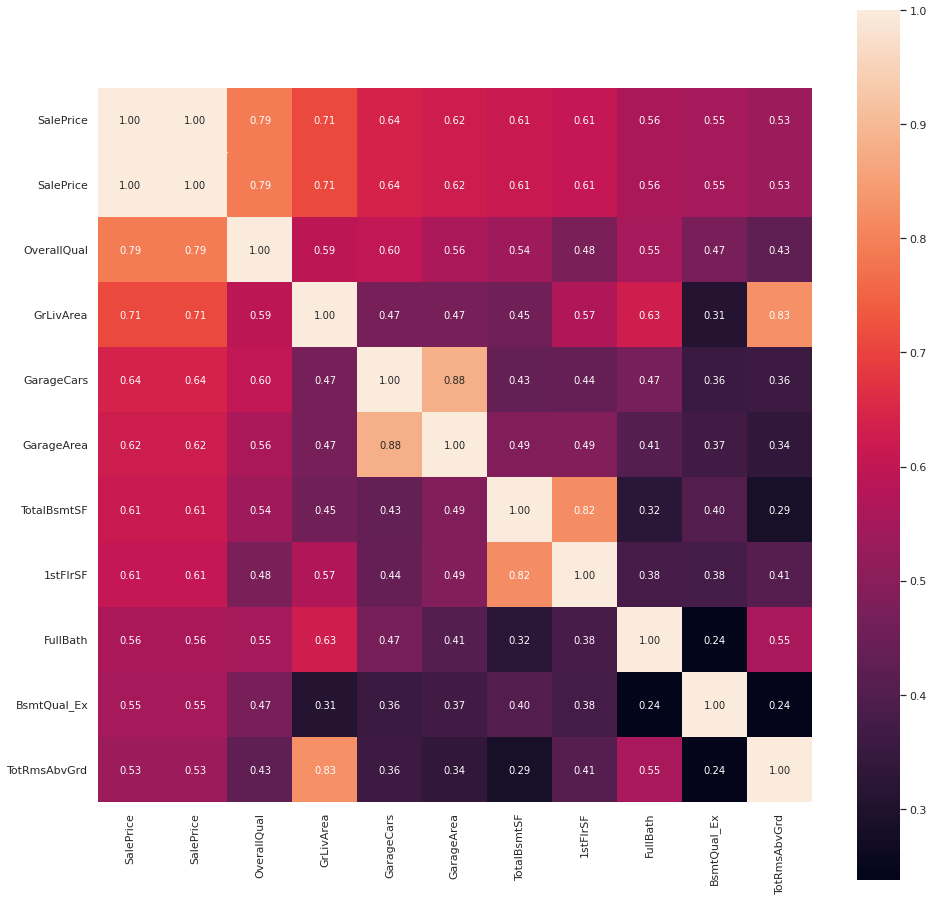

In [97]:
#Matriz de correlación
#Unicamente con las 10 variables mas correlacionadas.
heatMapCols=np.append(cols[-10:], np.array(['SalePrice']))
cm = np.corrcoef(train[heatMapCols[::-1]].T)
plt.figure(figsize=(16,16))
sns.set(font_scale=1)
with sns.axes_style("white"):
    sns.heatmap(cm,yticklabels=heatMapCols[::-1],xticklabels=heatMapCols[::-1],fmt='.2f',annot_kws={'size':10},annot=True,square=True,cmap=None)

In [98]:
train_label = train['SalePrice']

cols = np.delete(cols,len(cols)-1)

train_sample = train[cols]

test_sample = test[cols]

In [99]:
test_sample.head()


,BsmtUnfSF,Neighborhood_StoneBr,LotShape_IR1,BsmtFullBath,PavedDrive_Y,BsmtQual_Gd,GarageType_BuiltIn,RoofStyle_Hip,Electrical_SBrkr,HouseStyle_2Story,...,YearBuilt,TotRmsAbvGrd,BsmtQual_Ex,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,270.0,0,0,0.0,1,0,0,0,1,0,...,1961,5,0,1,896,882.0,730.0,1.0,896,5
1,406.0,0,1,0.0,1,0,0,1,1,0,...,1958,6,0,1,1329,1329.0,312.0,1.0,1329,6
2,137.0,0,1,0.0,1,1,0,0,1,1,...,1997,6,0,2,928,928.0,482.0,2.0,1629,5
3,324.0,0,1,0.0,1,0,0,0,1,1,...,1998,7,0,2,926,926.0,470.0,2.0,1604,6
4,1017.0,1,1,0.0,1,1,0,0,1,0,...,1992,5,0,2,1280,1280.0,506.0,2.0,1280,8


In [100]:
train_sample.head()

,BsmtUnfSF,Neighborhood_StoneBr,LotShape_IR1,BsmtFullBath,PavedDrive_Y,BsmtQual_Gd,GarageType_BuiltIn,RoofStyle_Hip,Electrical_SBrkr,HouseStyle_2Story,...,YearBuilt,TotRmsAbvGrd,BsmtQual_Ex,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,150.0,0,0,1.0,1,1,0,0,1,1,...,2003,8,0,2,856,856.0,548.0,2.0,1710,7
1,284.0,0,0,0.0,1,1,0,0,1,0,...,1976,6,0,2,1262,1262.0,460.0,2.0,1262,6
2,434.0,0,1,1.0,1,1,0,0,1,1,...,2001,6,0,2,920,920.0,608.0,2.0,1786,7
3,540.0,0,1,1.0,1,0,0,0,1,1,...,1915,7,0,1,961,756.0,642.0,3.0,1717,7
4,490.0,0,1,1.0,1,1,0,0,1,1,...,2000,9,0,2,1145,1145.0,836.0,3.0,2198,8


In [101]:
# se Sustituyen los valores nulos por la mediana
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer.fit(train_sample)

train_sample = imputer.transform(train_sample)
test_sample = imputer.transform(test_sample)

In [102]:
# Se normalizan los datos.
scaler = StandardScaler()

scaler.fit(train_sample)

train_sample = scaler.transform(train_sample)
test_sample = scaler.transform(test_sample)

print("Train: ",train_sample.shape)
print("Test: ", test_sample.shape)

Train (1460, 54)
(1459, 54)


In [103]:
#Se dividen los datos de entrenamiento y prueba, para poder comprobar la precisión del modelo.
X_train, X_test , y_train, y_test = train_test_split(train_sample,train_label,train_size = 0.8)

In [104]:
print("Train: ",X_train.shape)
print("Test: ",X_test.shape)
test_sample.shape

Train:  (1168, 54)
Test:  (292, 54)


(1459, 54)

In [105]:
#Se utiliza un regresor lineal.
model = LinearRegression()
model.fit(train_sample,train_label)

LinearRegression()

In [106]:
# Se predice el valor de las ventas
predict = model.predict(X_test)
# Se evalua la predicción del modelo (Error cuadrático medio)
print("Root Mean square error: " , np.sqrt(metrics.mean_squared_error(y_test,predict)))

Root Mean square error:  37620.66138281267


In [107]:
# Se aplica el modelo lineal a los datos de prueba y se guarda.
test_pred = model.predict(test_sample)
submit = pd.DataFrame()
submit['ID'] = testID
submit['SalePrice'] = test_pred
submit.to_csv('submission.csv', index=False)
submit.head()

,ID,SalePrice
0,1461,105409.918801
1,1462,159256.186754
2,1463,172951.238639
3,1464,193871.848436
4,1465,227398.667512


Score: 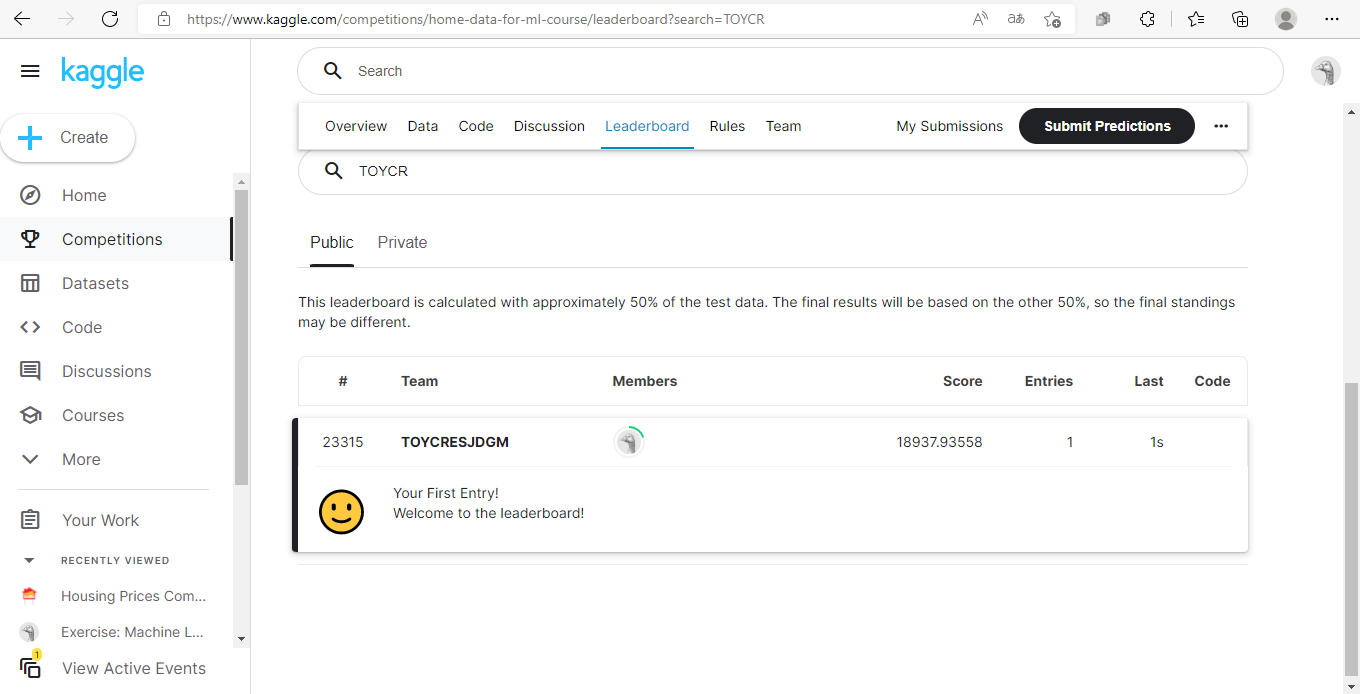